# Development of an Fast Fourier Transformation (FFT)

In [157]:
# Copyright (C) 2020 Danny Schneider
##
## This program is free software; you can redistribute it and/or
## modify it under the terms of the GNU General Public
## License as published by the Free Software Foundation;
## either version 2, or (at your option) any later version.
##
## Octave is distributed in the hope that it will be useful,
## but WITHOUT ANY WARRANTY; without even the implied
## warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR
## PURPOSE.  See the GNU General Public License for more
## details.
##
## You should have received a copy of the GNU General Public
## License along with Octave; see the file COPYING.  If not,
## write to the Free Software Foundation, 59 Temple Place -
## Suite 330, Boston, MA 02111-1307, USA.

In [158]:
clear all;
close all;

figcnt = 1;

## Functions

In [159]:
%%file my_log2base.m

## usage: answer = my_log2base(x,b)
##
## Returns the Logarithm of x to the Base b

## Original Author: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Original Maintainer: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Created: January 2009
## Version: 1.0
## Keywords: log, ln, logarithmic

function [result] = my_log2base(x,b)
  result = log(x) ./ log(b);
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_log2base.m'.


In [160]:
%%file my_is_integer.m

## usage: answer = my_is_integer(n)
## Returns true if n is an Integer

## Original Author: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Original Maintainer: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Created: June 2005
## Version: 1.0
## Keywords: integer, float

function [result] = my_is_integer(n)
  result = (mod(n,1) == 0);
  return;
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_is_integer.m'.


In [161]:
%%file my_is_number.m

## usage: answer = my_is_number(n)
##
## Returns true if n is NOT a matrix or vector with more than 1 Element

## Original Author: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Original Maintainer: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Created: June 2005
## Version: 1.0
## Keywords: number, vetor, matrix

function [result] = my_is_number(n)
    % Get dimension -> Vector
    dim = size(n);
    test = dim(1) + dim(2);
    if(test == 2)
        result = true;
    else
        result = false;
    endif
    return;
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_is_number.m'.


In [162]:
%%file my_is_vector.m

## usage: answer = my_is_vector(n)
##
## Returns true if n is a matrix with one Dimansion equal to 1

## Original Author: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Original Maintainer: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Created: June 2005
## Version: 1.0
## Keywords: vector, matrix, number

function [result] = my_is_vector(n)
  result = false;
  dim = size(n);
  if(my_is_number(n) == 0)
    if((dim(1) == 1) || (dim(2) == 1))
      if(dim(1) != dim(2))
        result = true;
      endif
    endif
  endif
  return;
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_is_vector.m'.


In [163]:
%%file test_for_powerof2.m

function result = test_for_powerof2(n)
  result = 0;
  r1 = my_log2base(n,2);
  r2 = mod(r1,1.0);
  if(r2 == 0.0)
    result = 1;
  endif
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/test_for_powerof2.m'.


In [164]:
%%file my_blackman.m

function result=my_blackman(N)
  d=N/2;
  n=((-d):1:(d-1));
  result=0.42 .+ (0.5 .* cos(1 .* pi .* n ./ d) .+ 0.08 .* cos(2 .* pi .* n ./ d));
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_blackman.m'.


## Why not just stick with the discrete Fourier Transform (DFT) ?

The advantage of the FFT over the DFT is, the work needed only is growing logarithmic instead of quadratic

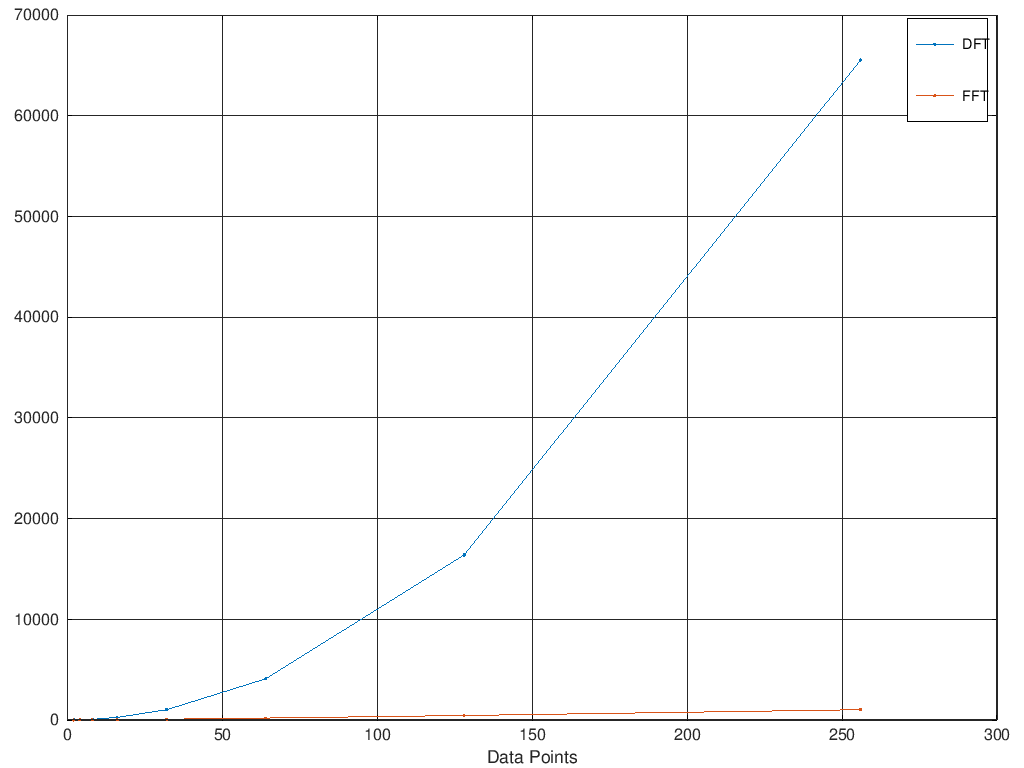

In [165]:
N = 2.^linspace(1,8,8);
quad=N.^2;
loga=(N.*my_log2base(N,2))./2;

figure(figcnt++)
plot(N,quad,'. -',N,loga,'. -');
xlabel("Data Points");
legend("DFT","FFT");
grid on;

## Fourier Series

$$f(t) = A_0 + \sum_{n=1}^{\infty} C_n \cdot sin (n \cdot \omega_0 t + \varphi_n)$$

$$ f(t) = A_0 + \sum_{n=1}^{\infty} A_n \cdot cos(n \cdot \omega_0 t) + B_n \cdot sin(n \cdot \omega_0 t)$$

## DFT

$$X \left(\frac{n}{NT}\right) = \sum_{k=0}^{N-1} x(kT) \cdot e^{-j \cdot 2 \cdot \pi \cdot \frac{n \cdot k}{N}}$$

inverse DFT

$$x(k \cdot T) = \frac{1}{N} \sum_{n=0}^{N-1} X \left(\frac{n}{NT} \right) \cdot e^{-j \cdot 2 \cdot \pi \cdot \frac{n \cdot k}{N}}$$

## Bitreverse


The second Half ist always the corresponding Value of the first Half +1 → we only need to calculate the first half and complement the missing Values according to this rule

It is easy to show that in the sorting scheme Values at one position relate to other Values → We can deduce rules how to calculate new Values when we know other Values, the Length of the Series and the Stage of Sorting

A Series with Length 2^Bits can be deduced of a Series with Length 2^(Bits-1) → Any Value of any Series with Length 2^Bits can recursivly calculated if we know the shortest possible Series with Length 2^0: {0,1}

Bitreverse sorted Series with Length: 2^2, 2^3, 2^4, 2^5
(Stage0 – unsorted Series)


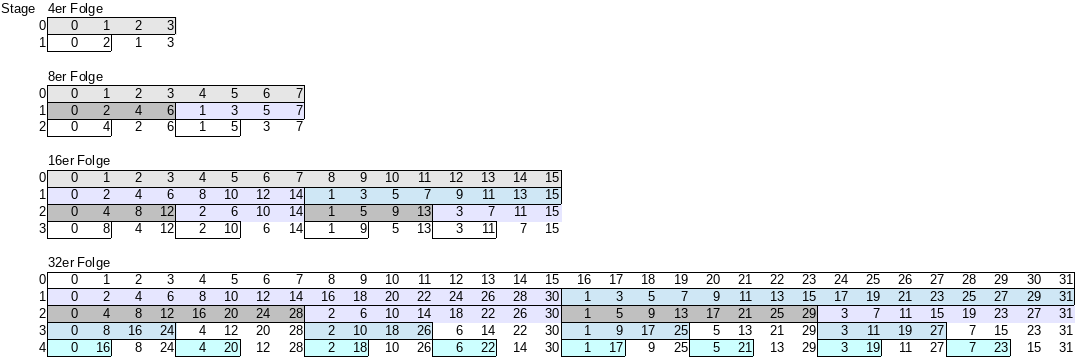

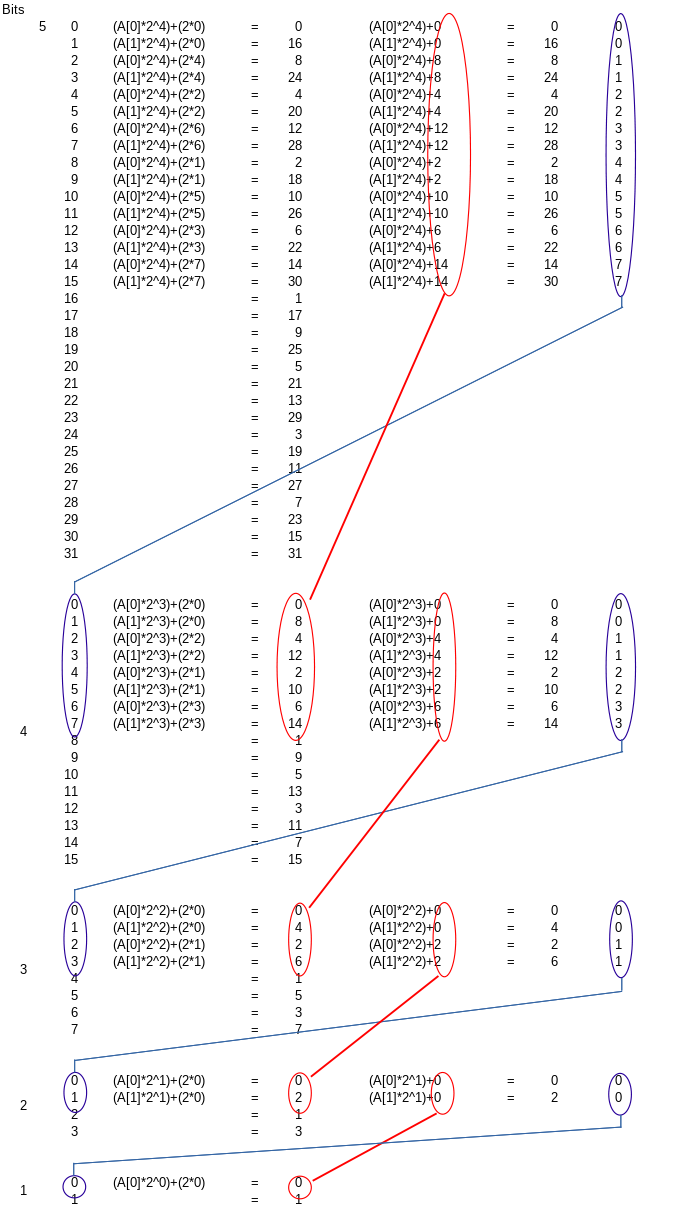

In [166]:
%%file my_reverse_number.m

## Calculate the Bitreverse of any given number n with max =(2^N)-1 
  function result=my_reverse_number(n,max)
    
    y = floor(my_log2base(max,2));
    z=0;
    a = (2.^(0:1:(y.-1)));
    b = (2.^(y.-(1:1:y)));
    for(i=1:1:y)
      if(n >= b(i))
        z+=a(i);
        n-=b(i);
      endif
    endfor

    result = z;
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_reverse_number.m'.


In [167]:
# Test for my_reverse_number

max = 2.^5;
result = zeros(1,max);
for(ii=linspace(0,(max.-1),max))
  result(:,ii.+1)=my_reverse_number(ii,max);
endfor
reference=result;
[result(1:(max./2));result(((max./2).+1):max)]

ans =

    0   16    8   24    4   20   12   28    2   18   10   26    6   22   14   30
    1   17    9   25    5   21   13   29    3   19   11   27    7   23   15   31



In [168]:
%%file my_bitreverse_01.m

##Bitrevers Sorting of an 1dim matrix, what is an array, which has 2^X Elements
##Here for every Number in the Array the function my_reverse_number is called which does the job
    
function result = my_bitreverse_01(sortarray)
    
    length = size(sortarray,2);
    
    if test_for_powerof2(length) == 0
      result = -1;
      return;
    endif

    len_half = length ./ 2;
 
    %Create and Sort an Series of 1,2,3,4,5,6,6,7,8,9.....(N-1)
    max = len_half-1;
    unsorted = 0:1:max;
    bitrev = zeros(1,length);

    %Calculate first half of Array
    for ii = 1:1:len_half
      %[unsorted(:,ii),my_reverse_number(unsorted(:,ii),max);]
      bitrev(:,ii)=my_reverse_number(unsorted(:,ii),length);
    endfor
#bitrev
    %Calculate second half of Array
    for ii = 1:1:len_half
      bitrev(:,ii+len_half) = bitrev(:,ii)+1;
    endfor 
#bitrev    
    %Re-Index Sortarray with the Bitrevers sorted Series
    result = zeros(1,length);    
    for ii = 1:1:length
      result(:,ii) = sortarray(:,(bitrev(:,ii) + 1));
    endfor
    
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_bitreverse_01.m'.


In [169]:
# Test for my_bitreverse_01

max = 2.^5;
input = linspace(0,(max.-1),max);
result = my_bitreverse_01(input);
[result(1:(max./2));result(((max./2).+1):max)]
sum(my_bitreverse_01(input).-reference)

ans =

    0   16    8   24    4   20   12   28    2   18   10   26    6   22   14   30
    1   17    9   25    5   21   13   29    3   19   11   27    7   23   15   31

ans = 0


In [170]:
%%file my_bitreverse_02.m

%%Bitrevers Sorting of an 1dim matrix or vector,
%%which is called an array in most programing languages,
%%The array length has to be 2^X Elements

%%Here the sorting is realized with heavy use of octaves [matlabs]
%%reshape function which manipulates matrizes in an not mathematical
%%way - it changes the dimension while preserving existing elements

function result = my_bitreverse_02(dataarray)

  dimension = size(dataarray);
  length    = dimension(2);
  if(0==test_for_powerof2(length))
    result = -1;
    return;
  endif

  sortarray = 0:2:(length.-1);
  length /= 2;

  dimorig = dimension;

  %%Resort Array with only the even numbes
  for(ii=1:1:my_log2base(length,2))
    array1=[];  %Empty Matrix
    for(ji=1:1:dimension(1))
      array1 = [array1;reshape(sortarray(ji,:),2,length / 2)];
    endfor
    sortarray = array1;
    dimension = size(sortarray);
    length    = dimension(2);
  endfor
  
  %%Reconstruct Array with even and odd numbers
  sortarray = [sortarray;sortarray + 1]';

  length = dimorig(2);
  %%Re-Index Sortarray with the Bitrevers sorted Series
  result = zeros(1,length);
  for(ii=1:1:length)
    result(:,ii) = dataarray(:,(sortarray(:,ii) + 1));
  endfor

endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_bitreverse_02.m'.


In [191]:
# Test for my_bitreverse_02

max = 2.^5;
input = linspace(0,(max.-1),max);
result = my_bitreverse_02(input);
[result(1:(max./2));result(((max./2).+1):max)]
sum(my_bitreverse_02(input).-reference)

ans =

    0   16    8   24    4   20   12   28    2   18   10   26    6   22   14   30
    1   17    9   25    5   21   13   29    3   19   11   27    7   23   15   31

ans = 0


In [171]:
%%file my_bitrev_pattern.m

## usage: result = my_bitrev_pattern(length)
## my_bitrev_pattern recursivly creates an array with half the length
## of the given Parameter Length. One Key Feature is that this Algorithm
## does not use Multiply. The resulting Pattern can be used to
## Calc the Bitrevers order of an Array in only two more easy steps
##
## Example calc the bitreverse order b of the series 0-31
##  x = 0:1:31;
##  evens = 0:2:(max(x));
##  odds  = evens .+ 1;
##  p= my_bitrev_pattern(32);
##  b = [p,p] .+ [evens,odds];

## Original Author: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Original Maintainer: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Created: June 2005
## Version: 1.0
## Keywords: FFT Butterfly Twiddles Twiddle-Factors

function result = my_bitrev_pattern(length)
    
  if length == 4
    result = [0,0];
  else
    length  = length./2;
    evens   = 0:2:(length-1);
    pattern = my_bitrev_pattern(length);
    bitrev  = pattern .+ evens;
    pattern = bitrev .+ pattern;
    second  = pattern(:,2); 
    result  = [pattern, pattern.-second];
  endif
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_bitrev_pattern.m'.


In [172]:
%%file my_bitreverse_03.m

function result = my_bitreverse_03(sortarray)
  
  length = size(sortarray,2);

  if(0==test_for_powerof2(length))
    result = -1;
    return;
  endif

  #First Half: all even Numbers of Range
  evens  = 0:2:(length-1);
  
  #Build magic tranformation pattern
  pattern = my_bitrev_pattern(length); #recursive buildup of sequence
  
  #Apply Pattern to Even Numbers
  bitrev = evens .+ pattern;
  
  #Extend: second half is first Half + 1
  bitrev = [bitrev,bitrev.+1];
  
  #Sort input Array with bitrev. sorted index
  result = zeros(1,length);    
  for(ii = 1:1:length)
    result(:,ii) = sortarray(:,(bitrev(:,ii) + 1));
  endfor
  
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_bitreverse_03.m'.


In [192]:
# Test for my_bitreverse_03

max = 2.^5;
input = linspace(0,(max.-1),max);
result = my_bitreverse_03(input);
[result(1:(max./2));result(((max./2).+1):max)]
sum(my_bitreverse_03(input).-reference)

ans =

    0   16    8   24    4   20   12   28    2   18   10   26    6   22   14   30
    1   17    9   25    5   21   13   29    3   19   11   27    7   23   15   31

ans = 0


In [173]:
%%file my_bitreverse_04.m

function result = my_bitreverse_04(sortarray)
    
  length = size(sortarray,2);

  if test_for_powerof2(length) == 0
      result = -1;
      return;
  endif

  Matlab_Offset = 1;

  ##Calc number of Stages needed for the sorting
  stages = my_log2base(length,2) .- 1;
%stages  
  ##Create Array of odd addresses
  unsorted  = (0:2:(length .- 1)) .+ Matlab_Offset;
  ##Create Array for sorted adresses
  sorted    = zeros(1,(length ./ 2));
  ##intial value for number of groups
  num_of_groups = 1;
  in_group = length;
  for stage = 2:1:stages
#actual_stage = stage
    ##Number of Groups in actual Stage
#unsorted
    ##Init value for put
    put = 1;
    num_of_groups *= 2;
    in_group      /= 2;
    for group = 0:1:(num_of_groups .- 1)
      #actual_group = group
      if (rem (group, 2) == 0)
        gadd = 2 * group;
      else
        gadd = 2 * (group .- 1) .+ 1;
      endif
      for baseindex = 1:2:in_group
# groupindex = baseindex .+ (in_group .* actual_group)
#[put++ , (baseindex + gadd)]
        sorted(:,put++) = unsorted(:,(baseindex + gadd));
      endfor
    endfor
#sorted
    unsorted = sorted;
  endfor

  ##Bitreverse sorted addresses
  addressing = [sorted,sorted + 1];
    
  ##Sort Sortarray with bitreverse sorted adresses
  result = zeros(1,length);
  for ii = 1:1:length
      take = addressing(:,ii);
      result(:,ii) = sortarray(:,take);
  endfor

endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_bitreverse_04.m'.


In [193]:
# Test for my_bitreverse_04

max = 2.^5;
input = linspace(0,(max.-1),max);
result = my_bitreverse_04(input);
[result(1:(max./2));result(((max./2).+1):max)]
sum(my_bitreverse_04(input).-reference)

ans =

    0   16    8   24    4   20   12   28   16    2   24   10   20    6   28   14
    1   17    9   25    5   21   13   29   17    3   25   11   21    7   29   15

ans = -16


In [174]:
%%file my_bitrevers.m

function result = my_bitrevers(sortarray)
    
    dimension = size(sortarray);
    ## Check if Sorrtarray is an Vector (one dimension has the value 1)
    if ( my_is_vector (sortarray) == 0 )
        printf("ERROR: Parameter must be an Vector\n");
        result = -1;
        return;
    ## Check if Array is transposed
    elseif(my_is_integer(my_log2base(dimension(2),2)) == false )
        printf("ERROR: Vector must have Length of 2^x \n");
        result = -1;
        return;
    elseif(dimension(1) != 1)
        printf ("Warning: Vector is transposed\n");
        sortarray = sortarray';
        dimension = size(sortarray);
        dimorig   = dimension;
    endif

## Different Versions of the Sorting Algorithem - activate only one!

#    result = my_bitreverse_01(sortarray);
#    result = my_bitreverse_02(sortarray);
    result = my_bitreverse_03(sortarray);
#    result = my_bitreverse_04(sortarray);
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_bitrevers.m'.


In [175]:
% Test the 3 functions for bitrevers Sorting an Array if all have
% the same result. This is true if the result of the Test is 1

function result = my_bitrevers_tester(maxbits)
    %maxbits = 10
    result = 0;
    for ii=3:1:maxbits
        data = 0:1:(2^ii - 1);
        br1 = my_bitreverse_01(data);
        br2 = my_bitreverse_02(data);
        br3 = my_bitreverse_03(data);
        br4 = my_bitreverse_04(data);
        brx = (br1 .+ br2 .+ br3) ./ 3;
        result += sum(brx .- br4)
        #bry = brx .- brx;
        #result += max(brx);
    endfor
%    for ii=3:1:maxbits
%        data = 1:1:(2^ii);
%        br1 = my_bitreverse_01(data);
%        br2 = my_bitreverse_02(data);
%        br3 = my_bitreverse_03(data);
%        brx = (br1 .+ br2) ./ 2;
%        bry = brx .- brx;
%        result += max(bry);
%    endfor
endfunction

In [176]:
my_bitrevers_tester(8)

result = 0
result = 0
result =  16
result = -48
result = -240
result =  720
ans =  720


In [177]:
%%file my_bitreverse_step_01.m

%Bitrevers Sorting of an 1dim matrix, what is an array, which has 2^X Elements
function result=my_bitreverse_step_01(v,step)
    
    dimorig = size(v);
    
    a = 2^(step - 1);
    b = dimorig(2) / a;
    
    y = b / 2;
    
    offset1 = y;
    offset2 = b;
    
    maxi = (dimorig(2) / a)-1;
    maxj = 2^(step - 1) - 1;
    
    z=zeros(dimorig);
    
    for j=0:1:maxj
        t1=1 + (j * offset2);
        for i=1:2:maxi
            %[t1,i+(j*offset2)]
            z(t1)=v(i+(j*offset2));
            t1++;
        endfor
        t1=1 + offset1 + (j * offset2);
        for i=1:2:maxi
            %[t1,i+1+(j*offset2)]
            z(t1)=v(i+1+(j*offset2));
            t1++;
        endfor
    endfor
    
    result = z;
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_bitreverse_step_01.m'.


In [178]:
%%file my_bitreverse_step_02.m

%Step of Bitrevers Sorting of an 1dim matrix or vector,
%which is called an array in most programing languages,
%The array length has to be 2^X Elements

%Here the sorting is realized with heavy use of octaves [matlabs]
%reshape function which manipulates matrizes in an NOT mathematical
%way - it changes the dimension while preserving existing elements

function result=my_bitreverse_step_02(sortarray,step)

    %Get actual dimensions
    dimorig = size(sortarray);
    
    a = 2^(step - 1);
    b = dimorig(2) / a;
    
    y = b / 2;
    
    offset1 = b;
    offset2 = 0;
    
    array2=[];
    for i=0:1:(a-1)
        array1 = reshape(sortarray(1,(1+offset2):(b+offset2)),2,y);
        offset2 = offset2 + offset1;
        array2 = [array2,array1(1,:)];
        array2 = [array2,array1(2,:)];
    endfor
    
    result = array2;
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_bitreverse_step_02.m'.


## Twiddles

In [179]:
%%file my_twiddle_factors.m

## usage: result = my_twiddle_factors(k,nos)
## Generates the Twiddle Factors for the FFT-Butterflys
## Parameter k can be supplied as a vector from 0 to N-1
## If supplied as a vector, the result is also a vector
## Parameter nos is the Number of Samples of the FFT

## Original Author: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Original Maintainer: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Created: June 2005
## Version: 1.0
## Keywords: FFT Butterfly Twiddles Twiddle-Factors

function result = my_twiddle_factors(k,nos)
  result = zeros(1,nos);
  d = (2.*pi.*k)./nos;
  for ii = 1:1:nos
    ##result(:,ii) = exp( complex( 0, -d .* (ii-1) ));
    result(:,ii) = exp(0.0.+ i.*(-d.*(ii.-1)));
  endfor
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_twiddle_factors.m'.


In [180]:
%%file my_get_twiddle_pair.m

## usage: result = my_all_twiddles(samples)
## Generates a matrix with all possible Twiddles used for a FFT with N Samples
## Results in Arrays with the Twiddle-Factors for every single Stage of an FFT
## An FFT for 8 Samples will have 3 Stages, an FFT for 16 Samples will
## have 4 Stages... and so on.

## Original Author: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Original Maintainer: Danny Schneider <Danny_Schneider_Hessen@web.de>
## Created: June 2005
## Version: 1.0
## Keywords: FFT Butterfly Twiddles Twiddle-Factors

function result = my_all_twiddles(nos)
    stages = my_log2base(nos,2)
    result = zeros(stages,nos);
    for ii = 1:1:stages
        result(ii,:) = my_twiddle_factors( (ii - 1), nos);
    endfor
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_get_twiddle_pair.m'.


In [181]:
%%file my_get_twiddle_pair.m

function result=my_get_twiddle_pair(twiddles,stage,butterfly)
  %Number of Twiddles
  not = length(twiddles);
  not_half = not/2;
  
  %Stage-offset
  stageoff = not/(2^stage);
  
  %Max Stage
  maxstage = my_log2base(not,2);
  
  %Max Butterfly
  maxbutterfly = not_half;
  
  %Number of different twiddle pairs
%    nodtp = 2^(stage-1);
    
  %Inverse Stage 
%    inv_stage = maxstage-stage + 1;
    
  imidiate=1:stageoff:(stageoff * maxbutterfly);
  
  index1=imidiate(butterfly);
  
  while (index1 > not_half)
      index1 = index1 - not_half;
  endwhile
  index2=index1+not_half;
  
  result = [twiddles(index1),twiddles(index2)];
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_get_twiddle_pair.m'.


In [182]:
#Twiddle Tester

nos=4 # e.g. 4-Point FFT
maxbutterfly=nos./2
maxstages=my_log2base(nos,2)
n=0:1:(nos.-1)
tw=my_twiddle_factors(n,nos)

for(index1=1:1:maxstages)
    for(index2=1:1:maxbutterfly)
        %stage=index1
        %butterfly=index2
        my_get_twiddle_pair(tw,index1,index2)
    endfor
endfor

nos =  4
maxbutterfly =  2
maxstages =  2
n =

   0   1   2   3

error: my_twiddle_factors: =: nonconformant arguments (op1 is 1x1, op2 is 1x4)
error: called from
    my_twiddle_factors at line 19 column 18
error: 'tw' undefined near line 5 column 29



## Butterfly

general definition:

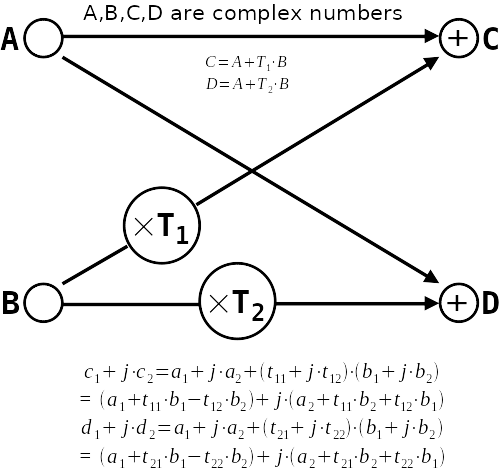

optimization for real number input

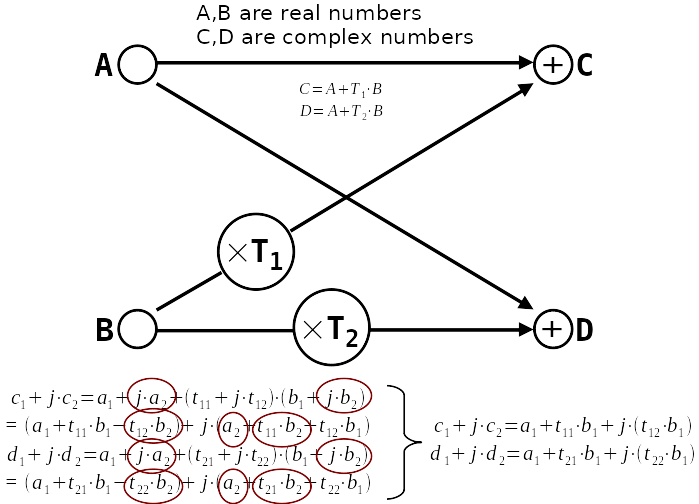

saved:
* 3x2 addtions with complex numbers
* 2x2 multiplications with complex numbers
total: 10 operations with complex numbers

In [183]:
%%file my_butterfly_complex.m

function result = my_butterfly_complex(x1,x2,y1,y2)
    a = x1 .+ (x2 .* y1);
    b = x1 .+ (x2 .* y2);
    result = [a,b];
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_butterfly_complex.m'.


In [184]:
%%file my_butterfly_vector.m

function result = my_butterfly_vector(x,y)
    x1 = x(1);
    x2 = x(2);
    y1 = y(1);
    y2 = y(2);
    result = my_butterfly_complex(x1,x2,y1,y2);
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_butterfly_vector.m'.


## The FFT

Example: 4 point FFT:

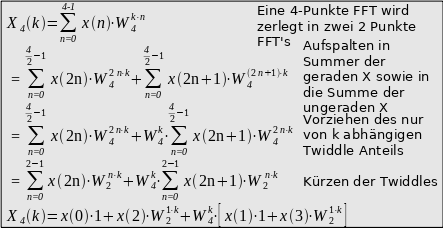


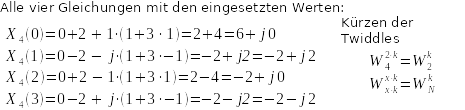

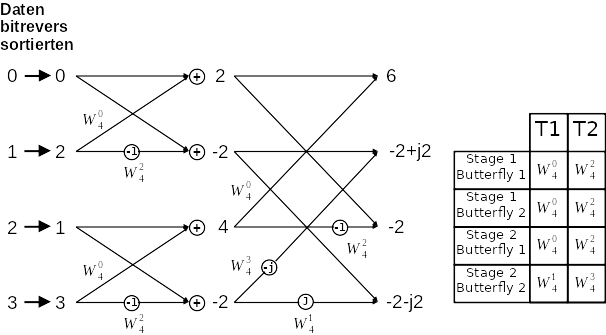

In [185]:
%%file my_fft_01.m

function result = my_fft_01(dataseries,fourierparameters)
% 2^n point FFT (Radix 2), decimation in time
% dataseries: complex valued input data sequence ; fourierparameter: Parameters for mathematica compatibility

  ## Extract Parameters
  a = fourierparameters(1);
  b = fourierparameters(2);

  ## Preparations
  N = size(dataseries,2);
  stages = my_log2base(N,2);
  result = zeros( size(dataseries));
#used_twids = zeros(2,N./2);

  ## Build Twiddle Table with Parameter b
  twiddles = my_twiddle_factors( b , N);
  
  ## Sort Data Bitrevers
  dataseries = my_bitrevers(dataseries);

  ## Do the FFT
  ##---------------------------------------------
  ## For all Stages
  
  butterfly_pos_offset = N / 2;
  twiddle_offset = N / 2;
  butterfly_width = 1;
  for sindex=1:1:stages
#stage = sindex
    num_of_butterfly_groups = 2^(stages - sindex);
    num_of_butterflys_per_group = 2^(sindex -1);
    
    ## For all Groups of Butterflys in the stage
    ## For every new Stage reset the A-Index
    Data_a_Index = 0;
#twid_count = 1;
    for bgindex=1:1:num_of_butterfly_groups
#butterfly_group = bgindex
      ## For all Butterflys in the Group
      Twiddle_a_index = 1;            
      for bfindex=1:1:num_of_butterflys_per_group
        ## Butterfly Number
#butterfly_index = bfindex
#butterfly = bgindex * bfindex
                
        ## Calculate the Twiddle Index and fetch the twiddles from the Array
        Twiddle_a = twiddles(:,Twiddle_a_index);
        Twiddle_b_index = Twiddle_a_index + twiddle_offset;
        Twiddle_b = twiddles(:,Twiddle_b_index);
#used_twids(:,twid_count++) = [Twiddle_a;Twiddle_b];                
        ## Calculate the Data-Pair Index
        ## inside a bf-Group count up the A-Index by one
        Data_a_Index += 1;
        Data_b_Index = Data_a_Index + butterfly_width;
        ## Fetch the Data from the Array
        Data_a = dataseries(:,Data_a_Index);
        Data_b = dataseries(:,Data_b_Index);
        
        ## Feeding the Butterfly Algorithm
        bf_result = my_butterfly_complex(Data_a,Data_b,Twiddle_a,Twiddle_b);
        result(:,Data_a_Index) = bf_result(1);
        result(:,Data_b_Index) = bf_result(2);
        
        ## Prepare Calculation of next Twiddle Index
        Twiddle_a_index += butterfly_pos_offset;                
      end ## For all Butterflys in the Group
      ## outside a bf-Group count up the A-Index by the width of a butterfly
      Data_a_Index += butterfly_width;            
    end ## For all Groups of Butterflys in the stage
    ## Copy Data back to input Array for next State
#used_twids
    dataseries = result;
    butterfly_pos_offset /= 2;
    ## The width of the butterfly's increases by two with each stage
    butterfly_width *= 2;
  end

  ## Scaling of the FFT Result with Parameter a
  result = (1 ./( N^( (1 .- a) ./ 2))) .* result;

endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_fft_01.m'.


In [186]:
%%file my_fft_02.m

## 2^n point FFT (Radix 2), decimation in time
## inputdata:        complex valued input data sequence
## fourierparameter: Parameters for mathematica compatibility
function result = my_fft_02(inputdata,fourierparameters)
  a = fourierparameters(1);
  b = fourierparameters(2);
  
  %Number of Samples
  N = size(inputdata,2)
  
  %Array with numbers from 0 to N-1
  helper = linspace(0,(N-1),N)
  
  %Number of Stages of the FFT
  stages = my_log2base(N,2)

  %Two Dimensional Array with Twiddles
  twiddles= [ ];
  for iindex = 1:1:stages
    twiddles = [twiddles;my_twiddle_factors(b*helper,2^iindex)];
  end

  %Debug Output of the calculated Twiddles
  twiddles
  
  %Bitrevers Sorting of the Input data
  inputdata = my_bitrevers(inputdata)

  helper=helper.+1
  for(iindex=1:1:stages)
    for(jindex=1:2:N)
      inputdata(helper(jindex:(jindex.+1)) = my_butterfly_vector(inputdata(helper(jindex:(jindex.+1)),twiddles(iindex,helper(jindex:(jindex.+1)));
    end
    helper = my_bitrevers_step(helper,iindex);
  end

  inputdata = (1./(N.^((1.-a)./2))).*inputdata;

  result = inputdata;

endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_fft_02.m'.


In [187]:
%%file my_fft.m

function result = my_fft(dataseries,fourierparameters)
  result = my_fft_01(dataseries,fourierparameters);
  #result = my_fft_02(dataseries,fourierparameters);
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_fft.m'.


In [188]:
%%file my_scaled_fft.m

function result=my_scaled_fft(data,fp,maxfreq)
  Nby2=size(data,2)./2;
  freq = linspace(0,(maxfreq./2),Nby2);
  result = 20.*log10(abs(my_fft(data,fp)(1:Nby2) ));
endfunction

Created file '/home/danny/Dokumente/Jupyter_Notebooks/octave/my_scaled_fft.m'.


## Testing

N =  1024
weighted_diff = -6.2905e-13 + 2.5745e-13i
weighted_diff =  5.6595e-17 + 3.7547e-16i


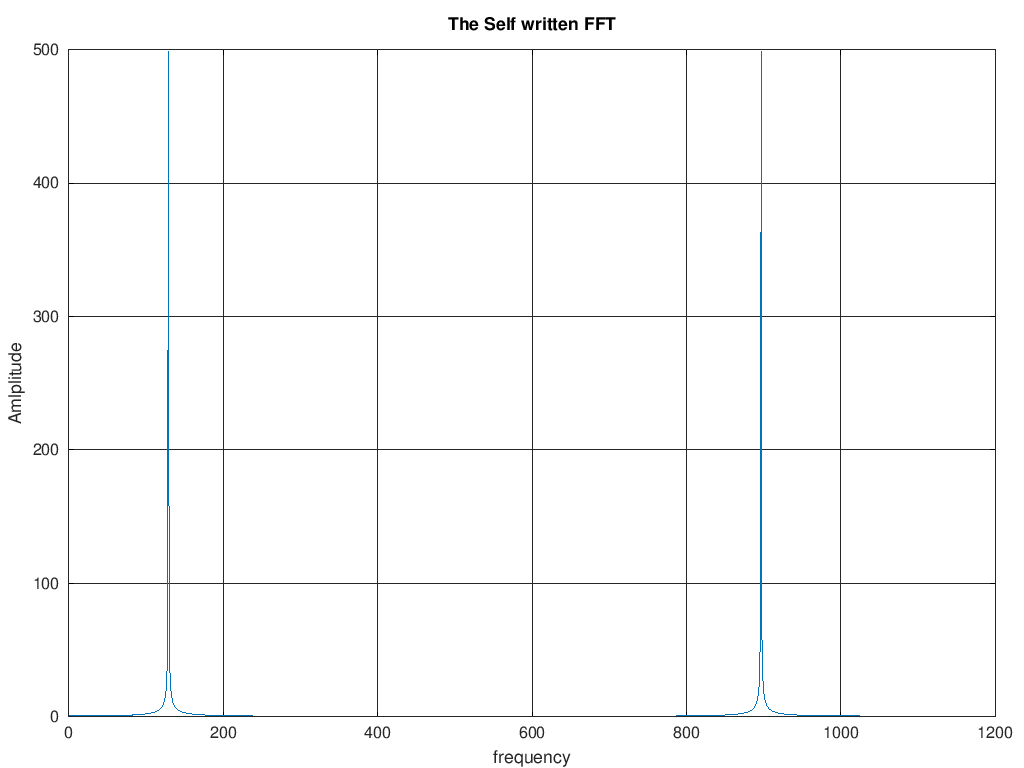

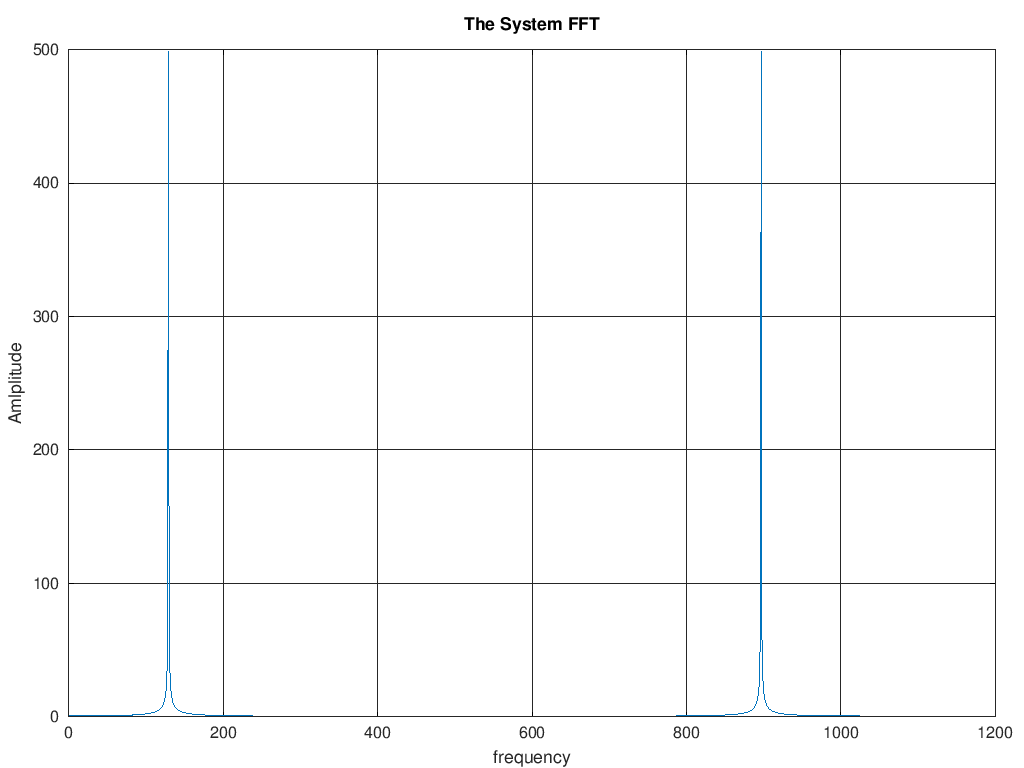

In [189]:
N = 1024
test = 0:1:(N.-1);

systemfft = fft(test);
selffft   = my_fft(test,[1,1]);
weighted_diff = sum( systemfft .- selffft ) ./ length(test)

#
#-----
#

test = sin( 2 .* pi .* 128 .* (0:1./(N.-1):1) + pi ./ 4);
systemfft = fft(test);
selffft   = my_fft(test,[1,1]);
weighted_diff = sum( systemfft .- selffft ) ./ length(test)

#
#-----
#

figure(figcnt++);
plot(abs(fft(test)));
title "The System FFT";
xlabel "frequency";
ylabel "Amlplitude";
grid on;

#
#-----
#

figure(figcnt++);
plot(abs(my_fft(test,[1,1])));
title "The Self written FFT";
xlabel "frequency";
ylabel "Amlplitude";
grid on;

In [ ]:
#
#-----
#

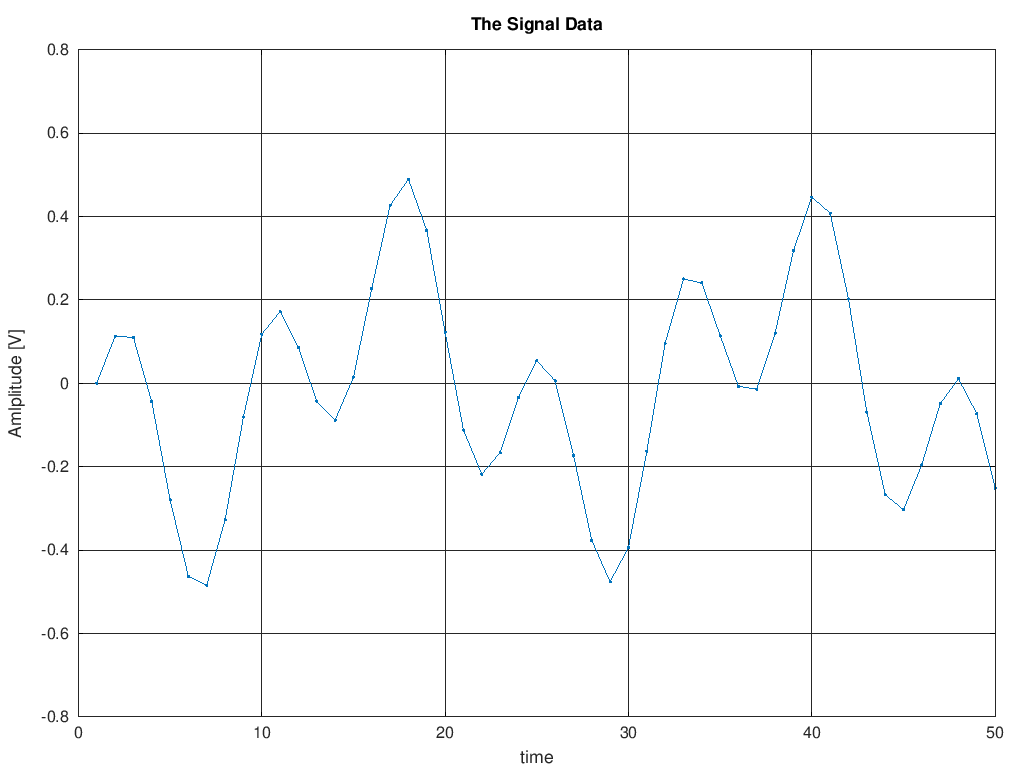

In [199]:
%Number of Samples (currently only 2^x is supported)
#N = 4;
#N = 8;
#N = 16;
N = 1024;
Nby2 = N ./ 2;

%Test Data Sequences
#test=[0 1 2 3];
#test=[0 1 2 3 4 5 6 7];
#test=[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15];
n=0:1:(N.-1);
fsig1=11;
fsig2=23;
test=sin(2.*pi.*fsig1.*n./(N/4)).*0.5.*cos(2.*pi.*fsig2.*n./(N/4));
#test = sin( 2 .* pi .* 128 .* (0:1./(N-1):1) + pi ./ 4);

dataseries=test;

%Plot Data
h=figure(figcnt++);
plot(dataseries(1:1:50),'. -');
title "The Signal Data";
xlabel "time";
ylabel "Amlplitude [V]";
grid on;
#dataseries
##length(dataseries)

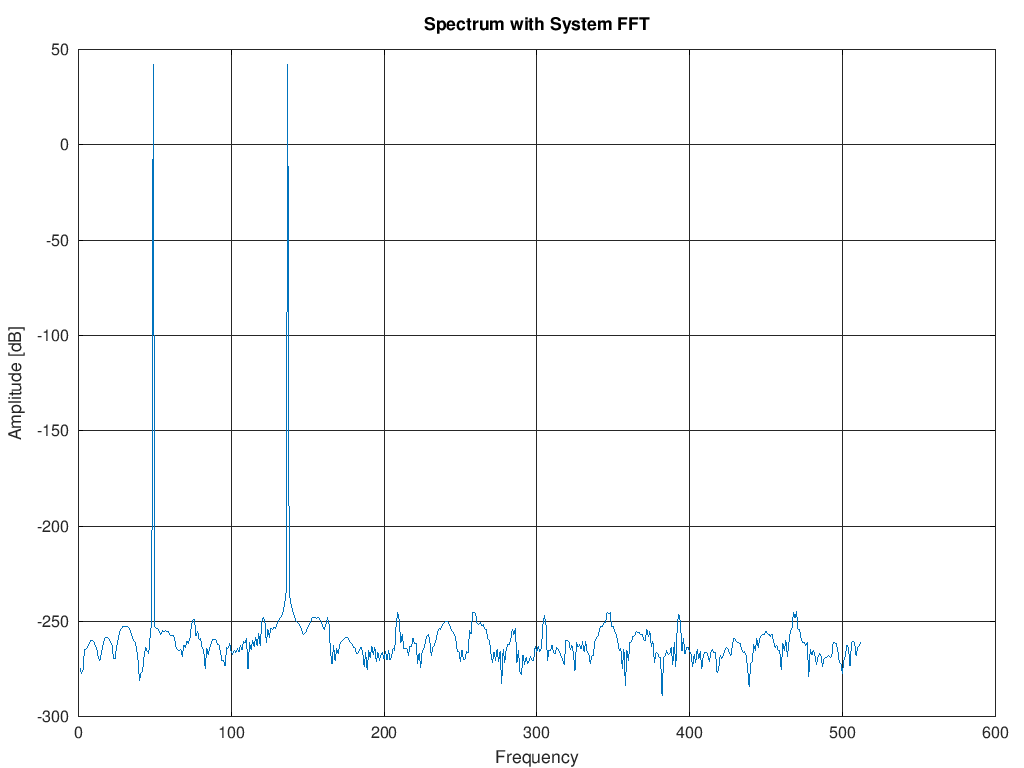

In [195]:
%Plot Spectrum with System FFT
h=figure(figcnt++);
plot(20.*log10(abs(fft(dataseries)(1:1:(Nby2)))));
title "Spectrum with System FFT";
xlabel "Frequency";
ylabel "Amplitude [dB]";
grid on;
##length(dataseries)
##length(fft(dataseries))
##[dataseries;fft(dataseries)]

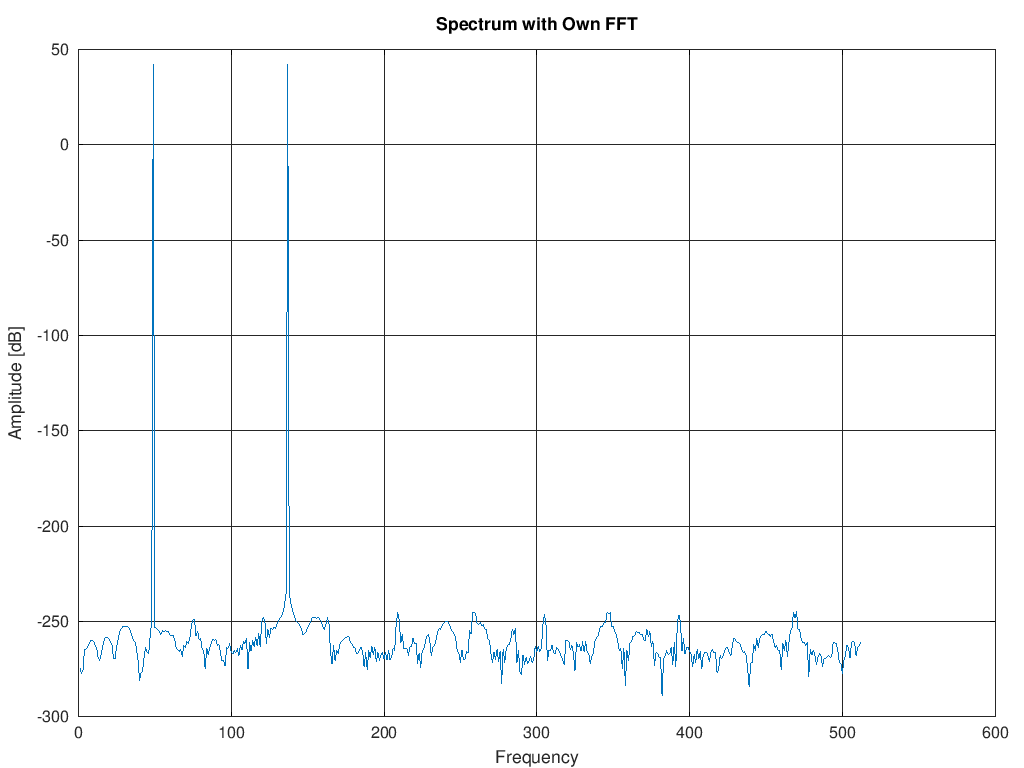

In [196]:
%Plot Spectrum with Own FFT
h=figure(figcnt++);
plot(20.*log10(abs(my_fft(dataseries,[1,+1])(1:1:(Nby2)))));
title "Spectrum with Own FFT";
xlabel "Frequency";
ylabel "Amplitude [dB]";
grid on;
##[dataseries;my_fft(dataseries,[1,1])]
##length(dataseries)
##length(my_fft(dataseries,[1,1]))

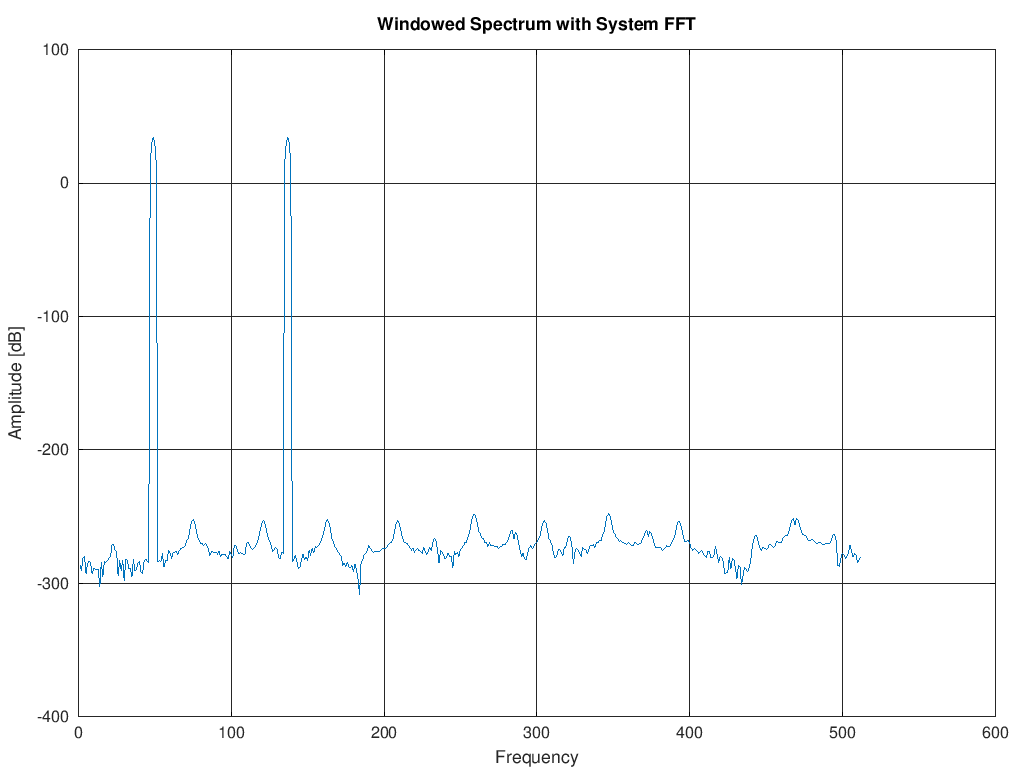

In [197]:
%Handle Spectral Effects due Windowing
dataseries=dataseries .* my_blackman(N);

%Plot Windowed Spectrum with System FFT
h=figure(figcnt++);
plot(20.*log10(abs(fft(dataseries)(1:1:(Nby2)))));
title "Windowed Spectrum with System FFT";
xlabel "Frequency";
ylabel "Amplitude [dB]";
grid on;
##[dataseries;fft(dataseries)]
##length(dataseries)
##length(fft(dataseries))

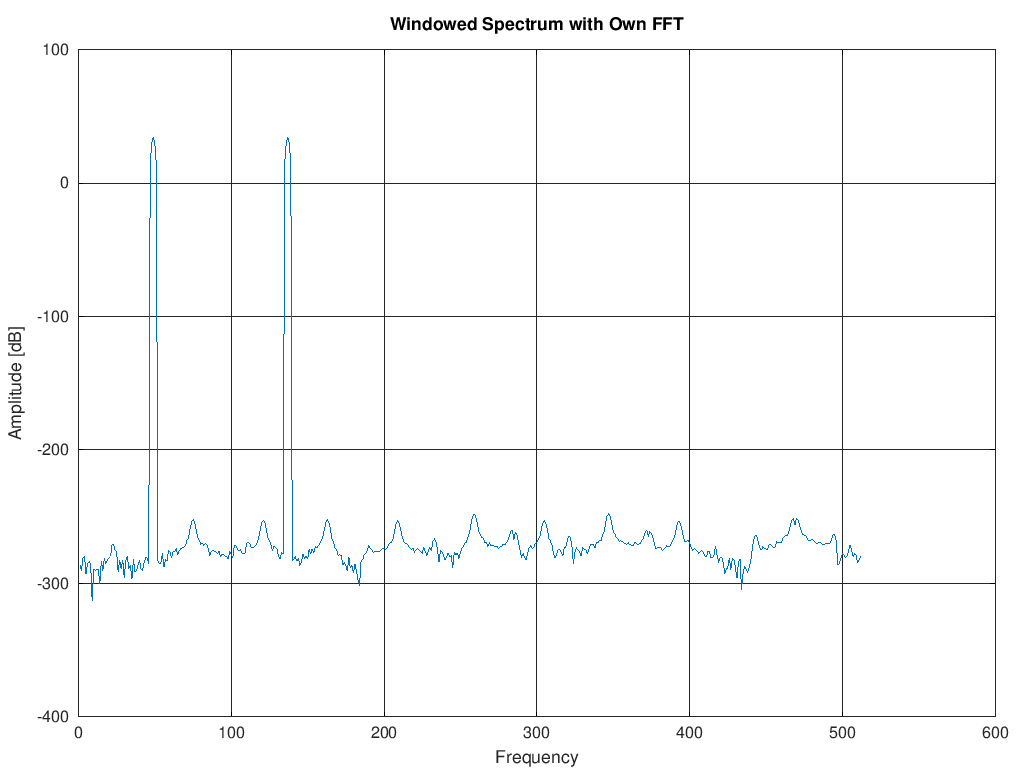

In [198]:
%Plot Windowed Spectrum with Own FFT
h=figure(figcnt++);
plot(20.*log10(abs(my_fft(dataseries,[1,+1])(1:1:(Nby2)))));
title "Windowed Spectrum with Own FFT";
xlabel "Frequency";
ylabel "Amplitude [dB]";
grid on;
##[dataseries;my_fft(dataseries,[1,1])]
##length(dataseries)
##length(my_fft(dataseries,[1,1]))

##my_plot_scaled_fft(dataseries)

## periodic mirroring of spectrum

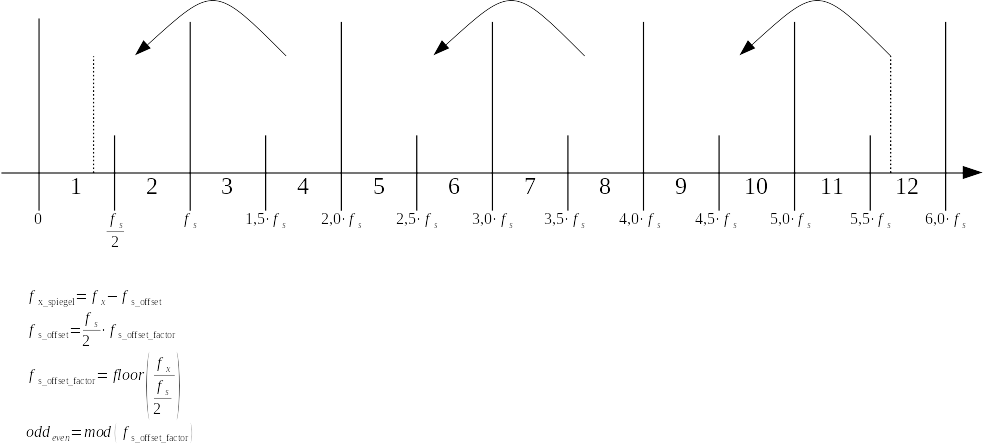